Import potrebnih knjižnic za analizo podatkov:

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import signal

Prebiranje datotek s podakti, tukaj se ignorira vrstice, ki pokvarijo strukturo podatkov oziroma v originalni datoteki niso del podatkov temvec prazna vrstica ipd. 
V programski kodi so seveda zamaknjene za -1.

Izberemo tudi samo stolpce z izbranimi točkami:  
A - datumi  
B - povprecje  
C:IW - izbrane tocke  


od IW naprej so pa stolpci prazni in nekje v koncu dokumenta spet nekatere vrednosti, ki niso pomembne

Stolpec z datumi se spremeni v datume.

preberemo se za pretok, po stoplcih:  
A - datum  
B - pretok  
C - prazen  
D - temp. vode  
E - mot. vode  

se preimenujem pretok da bo lazje obdelovati

zdrzuimo oba dataframa s concat (axis = 1 pomeni da po stolpcih)


In [28]:
file_path = 'podatki/Rizana_Zaledje_INCA_dnev_2020_2021_N1.xlsx'
df_padavine = pd.read_excel(file_path, sheet_name='Izbrane', skiprows=[0, 1, 3, 4], usecols="A,C:IW")

df_padavine["datum"] = pd.to_datetime(df_padavine["datum"], format="%m/%d/%y")
df_padavine = df_padavine.set_index('datum')

file_path1 = 'podatki/Pretok_2020_2021_N1.xlsx'
df_pretok = pd.read_excel(file_path1, sheet_name='meritve', usecols="A, B")
df_pretok.rename(columns={"pretok (m3/s)": "pretok"}, inplace=True)

df_pretok["datum"] = pd.to_datetime(df_pretok["datum"], format="%d.%m.%Y")
df_pretok = df_pretok.set_index('datum')

df = pd.concat([df_pretok, df_padavine], axis=1)


### Normalne vrednosti in % odstopanja
- pogledati je treba katere so normalne vrednosti in kakšen procent predstavlja znatno odstopanje

Velikost: (731, 256)
Toliko vrstic vsebuje Nan: 0
Povprečni pretok: 2.757
Mediana pretok: 0.909
Najbolj pogost pretok: 0.193


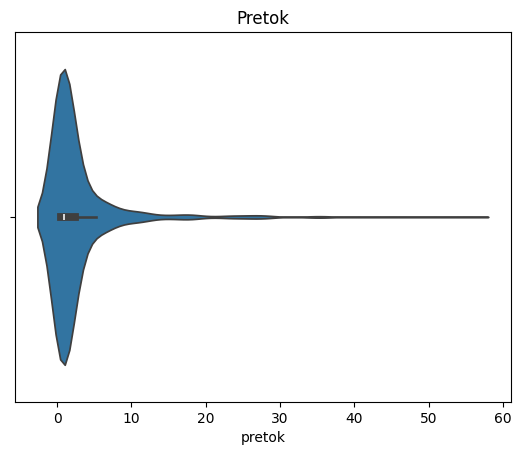

In [31]:
print(f"Velikost: {df.shape}")
#print(f"Stolpci: {df.columns.tolist()}")
"""
x = 5
print(df_pretok.head(x))
print(df_padavine.head(x))
print(df.sample(x))
"""
print(f"Toliko vrstic vsebuje Nan: {df.isna().any(axis=1).sum()}")

#zaokroženo na 3 mesta kot podatki
avgPretok = df['pretok'].mean().round(3) 
modPretok = df["pretok"].mode().iloc[0] 
#mode vrne vecje stevilo zato treba z iloc preveriti prvega ne glede na index
medPretok = df["pretok"].median().round(3)

print(f"Povprečni pretok: {avgPretok}")
print(f"Mediana pretok: {medPretok}")
print(f"Najbolj pogost pretok: {modPretok}")

sns.violinplot(x=df['pretok']) #za data distribution
plt.title("Pretok")
plt.show()

### Isolation forest anomaly detection


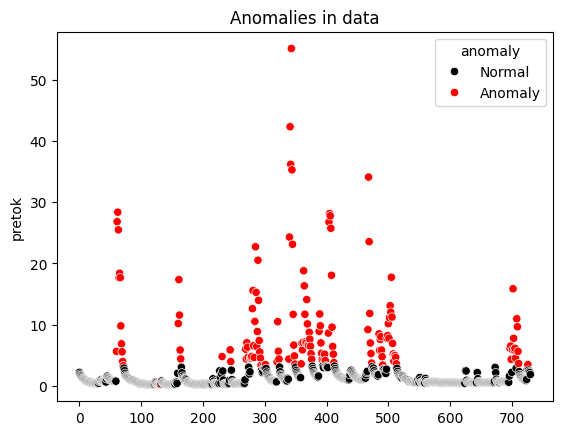

,pretok,68,69,95,96,97,98,122,123,124,...,567,570,571,572,573,574,575,596,601,anomaly
datum,,,,,,,,,,,,,,,,,,,,,
2020-05-29,0.267567,1.99,1.19,2.34,1.60,1.36,1.85,2.29,1.68,1.10,...,4.11,3.84,4.12,3.45,2.74,2.91,3.99,4.61,3.19,Normal
2021-04-26,1.680120,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2021-01-09,6.452523,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Anomaly
2020-03-19,1.354000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2021-06-08,1.500838,2.53,1.94,2.07,2.69,0.72,1.87,2.45,3.05,1.99,...,6.09,10.58,11.46,18.82,13.45,10.56,10.96,5.23,17.94,Normal
2021-04-06,1.217296,1.51,1.59,1.39,1.68,1.58,1.66,1.19,1.61,1.49,...,0.01,0.02,0.03,0.04,0.05,0.09,0.13,0.02,0.04,Normal
2021-01-27,5.291153,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Anomaly
2021-11-23,0.669037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal
2020-03-05,17.660000,0.28,0.00,0.00,0.00,0.00,0.00,1.09,0.26,0.33,...,0.00,0.00,0.00,0.66,1.76,1.51,1.59,0.00,2.28,Anomaly


In [32]:
model = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, random_state=42, bootstrap=False)

stolpec = "pretok"

model.fit(df[[stolpec]])
df['anomaly'] = model.predict(df[[stolpec]])
#df['score'] = model.score_samples(df[[stolpec]])
df['anomaly'] = df['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

sns.scatterplot(x=range(len(df)), y=stolpec, hue='anomaly', data=df, palette=['black', 'red'])
plt.title('Anomalies in data')
plt.show()

df.sample(10)


The signals are offset by: 0 units
Senzor je ta: 68


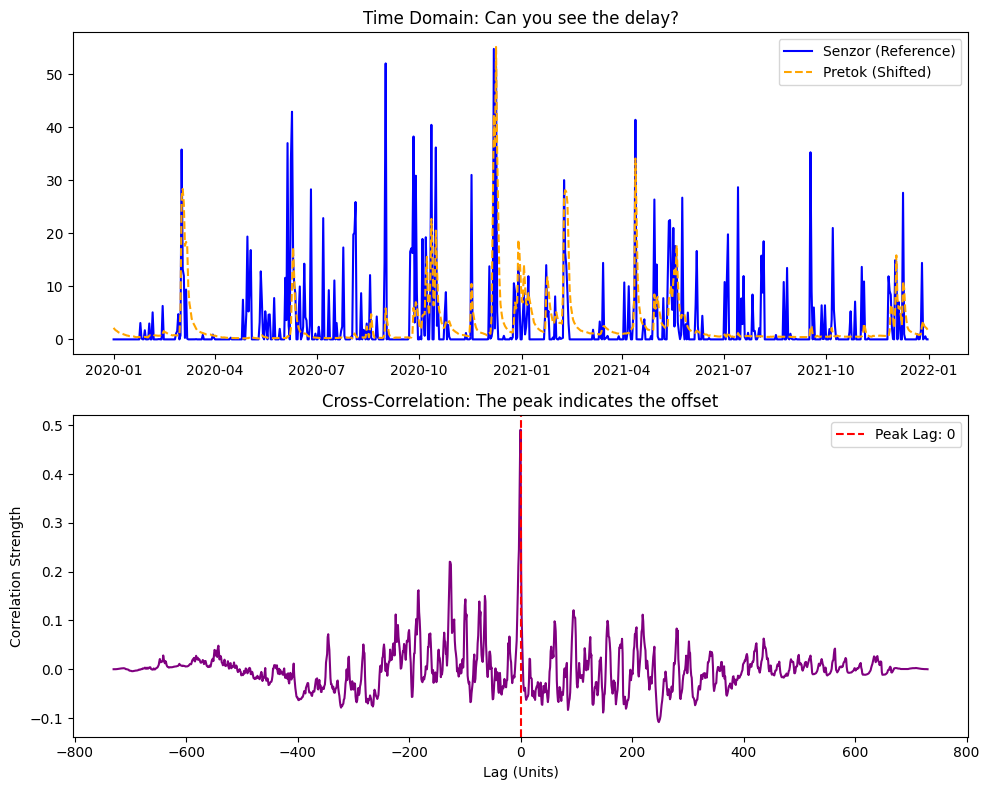

In [36]:
# Opcija zmanjsanja podatkov
#df = df.loc['2020-10-01':'2020-10-07']

signal2 = df["pretok"]

for senzor in df.columns[1:2]: #za vse [1:-2]
    #senzor = df.columns.to_series()[1:-2].sample(1).values[0]
    signal1 = df[senzor]

    # normalizacija
    sig1_norm = (signal1 - np.nanmean(signal1)) / (np.nanstd(signal1) * len(signal1))
    sig2_norm = (signal2 - np.nanmean(signal2)) / (np.nanstd(signal2))

    correlation = signal.correlate(sig1_norm, sig2_norm, mode='full')
    lags = signal.correlation_lags(len(signal1), len(signal2), mode='full')

    found_lag = lags[np.argmax(correlation)]
    print(f"The signals are offset by: {found_lag} units")
    print("Senzor je ta: " + senzor)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(signal1, label='Senzor (Reference)', color='blue')
    ax1.plot(signal2, label='Pretok (Shifted)', color='orange', linestyle='--')
    ax1.set_title('Time Domain: Can you see the delay?')
    ax1.legend()

    ax2.plot(lags, correlation, color='purple')
    ax2.axvline(x=found_lag, color='red', linestyle='--', label=f'Peak Lag: {found_lag}')
    ax2.set_title('Cross-Correlation: The peak indicates the offset')
    ax2.set_xlabel('Lag (Units)')
    ax2.set_ylabel('Correlation Strength')
    ax2.legend()

    plt.tight_layout()
    plt.show()
